In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import statsmodels.api as sm

In [2]:
import torch
import torch.nn as nn
from torch.utils.data import DataLoader, TensorDataset, random_split
import torch.nn.functional as F
from torch.optim.lr_scheduler import ReduceLROnPlateau 
torch.cuda.is_available()

True

# Preprocessing

In [3]:
df_train = pd.read_csv('./datasets/train-v3.csv')
df_train.head(10)

,id,price,sale_yr,sale_month,sale_day,bedrooms,bathrooms,sqft_living,sqft_lot,floors,...,grade,sqft_above,sqft_basement,yr_built,yr_renovated,zipcode,lat,long,sqft_living15,sqft_lot15
0,5615100330,200000,2015,3,27,4,2.00,1900,8160,1,...,7,1900,0,1975,0,98022,47.2114,-121.986,1280,6532
1,8835900086,350000,2014,9,2,4,3.00,3380,16133,1,...,8,2330,1050,1959,0,98118,47.5501,-122.261,2500,11100
2,9510900270,254000,2014,12,11,3,2.00,2070,9000,1,...,7,1450,620,1969,0,98023,47.3085,-122.376,1630,7885
3,2621600015,175000,2015,4,30,3,1.00,1150,8924,1,...,6,1150,0,1943,0,98030,47.3865,-122.217,1492,8924
4,8078350090,619000,2015,3,31,3,2.50,2040,7503,2,...,8,2040,0,1987,0,98029,47.5718,-122.021,2170,7503
5,1061400180,240000,2015,1,6,3,1.00,1550,12670,1,...,7,1550,0,1962,0,98056,47.5024,-122.169,1550,8880
6,7697870600,158000,2014,9,9,3,2.50,1520,7200,2,...,7,1520,0,1985,0,98030,47.3679,-122.182,1780,7210
7,7812800995,200000,2014,9,5,2,1.00,790,5985,1,...,6,790,0,1944,0,98178,47.4941,-122.240,1030,5985
8,2953000250,275000,2014,7,31,3,1.50,1900,9737,1,...,7,1200,700,1968,0,98031,47.4125,-122.207,1670,9737
9,5561400740,593500,2015,2,10,5,3.25,4300,50405,2,...,8,3220,1080,1972,0,98027,47.4615,-122.000,2680,41684


In [4]:
#check columns whether null
df_train.isnull().sum()

id               0
price            0
sale_yr          0
sale_month       0
sale_day         0
bedrooms         0
bathrooms        0
sqft_living      0
sqft_lot         0
floors           0
waterfront       0
view             0
condition        0
grade            0
sqft_above       0
sqft_basement    0
yr_built         0
yr_renovated     0
zipcode          0
lat              0
long             0
sqft_living15    0
sqft_lot15       0
dtype: int64

In [5]:
df_train.describe()

,id,price,sale_yr,sale_month,sale_day,bedrooms,bathrooms,sqft_living,sqft_lot,floors,...,grade,sqft_above,sqft_basement,yr_built,yr_renovated,zipcode,lat,long,sqft_living15,sqft_lot15
count,1.296700e+04,1.296700e+04,12967.000000,12967.000000,12967.000000,12967.000000,12967.000000,12967.000000,1.296700e+04,12967.000000,...,12967.000000,12967.000000,12967.000000,12967.000000,12967.000000,12967.000000,12967.000000,12967.000000,12967.000000,12967.000000
mean,4.588968e+09,5.373833e+05,2014.322511,6.572068,15.729930,3.362381,2.106058,2071.295057,1.499539e+04,1.442893,...,7.646025,1781.741806,289.553251,1970.766947,82.948870,98078.459166,47.558910,-122.214565,1980.143672,12796.538290
std,2.877996e+09,3.668840e+05,0.467455,3.107792,8.619505,0.941124,0.765280,919.355180,3.875191e+04,0.551628,...,1.171189,826.580915,440.742634,29.472777,398.333729,53.525055,0.138978,0.140481,683.572323,27429.856166
min,1.000102e+06,7.500000e+04,2014.000000,1.000000,1.000000,0.000000,0.000000,290.000000,5.720000e+02,1.000000,...,1.000000,290.000000,0.000000,1900.000000,0.000000,98001.000000,47.159300,-122.515000,399.000000,659.000000
25%,2.134110e+09,3.199500e+05,2014.000000,4.000000,8.000000,3.000000,1.500000,1420.000000,5.040000e+03,1.000000,...,7.000000,1190.000000,0.000000,1951.000000,0.000000,98033.000000,47.470450,-122.330000,1480.000000,5100.000000
50%,3.905000e+09,4.470000e+05,2014.000000,6.000000,16.000000,3.000000,2.250000,1900.000000,7.620000e+03,1.000000,...,7.000000,1550.000000,0.000000,1974.000000,0.000000,98065.000000,47.569900,-122.232000,1830.000000,7625.000000
75%,7.326850e+09,6.370000e+05,2015.000000,9.000000,23.000000,4.000000,2.500000,2540.000000,1.063400e+04,2.000000,...,8.000000,2200.000000,560.000000,1996.000000,0.000000,98118.000000,47.677300,-122.125000,2350.000000,10051.000000
max,9.900000e+09,7.062500e+06,2015.000000,12.000000,31.000000,33.000000,8.000000,13540.000000,1.024068e+06,3.000000,...,13.000000,9410.000000,4820.000000,2015.000000,2015.000000,98199.000000,47.777600,-121.315000,6210.000000,871200.000000


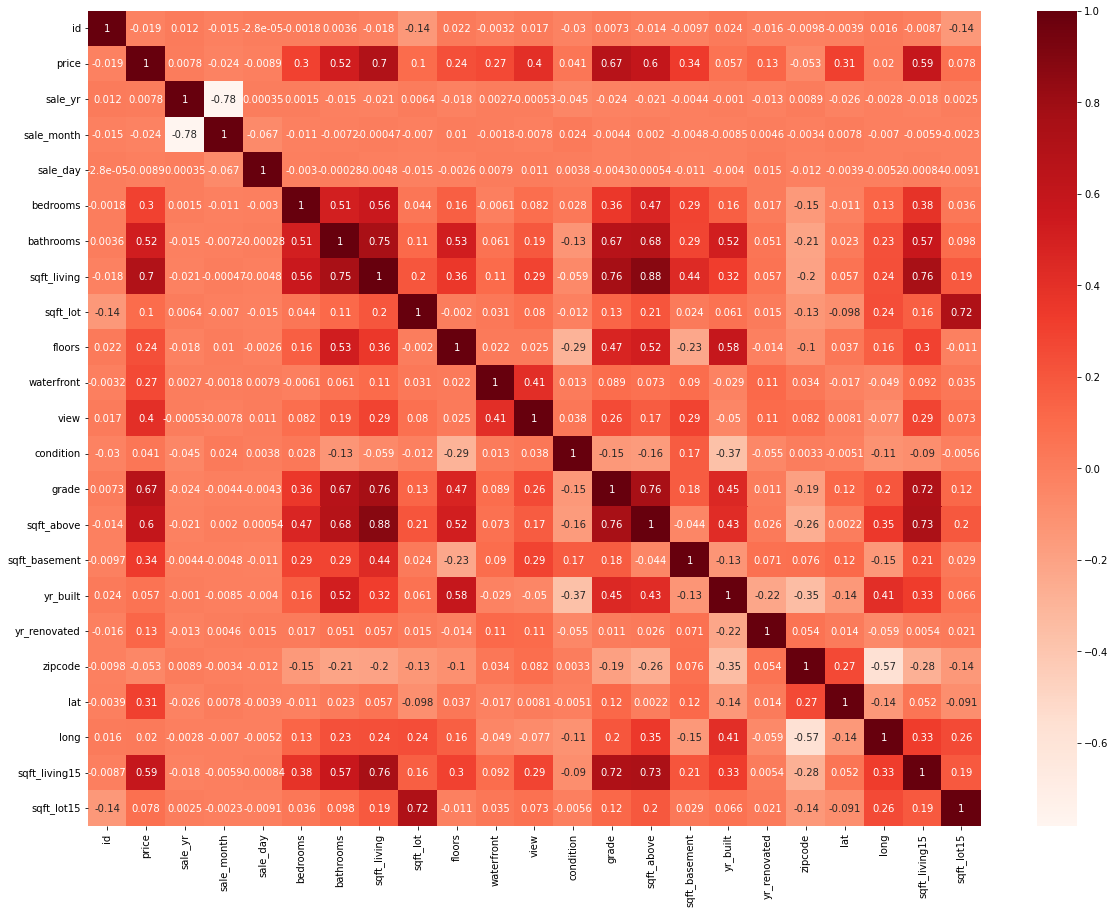

In [6]:
# correlation heatmap
cor = df_train.corr()
plt.figure(figsize=(20,15))
sns.heatmap(cor, annot=True, cmap=plt.cm.Reds)
plt.show()

In [7]:
#check the affects of columns in correlation value, 
#we know id, sale_day, sale_month, zipcode might interfere the accuracy
df_train.corr()["price"].sort_values(ascending=False)

price            1.000000
sqft_living      0.702100
grade            0.672523
sqft_above       0.601167
sqft_living15    0.586408
bathrooms        0.521330
view             0.404273
sqft_basement    0.337082
lat              0.309688
bedrooms         0.301817
waterfront       0.266653
floors           0.241054
yr_renovated     0.129219
sqft_lot         0.101519
sqft_lot15       0.078428
yr_built         0.057491
condition        0.040836
long             0.020066
sale_yr          0.007752
sale_day        -0.008888
id              -0.018552
sale_month      -0.024029
zipcode         -0.052930
Name: price, dtype: float64

D:\64bits\anaconda\envs\pt-gpu\lib\site-packages\seaborn\distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


<AxesSubplot:xlabel='price', ylabel='Density'>

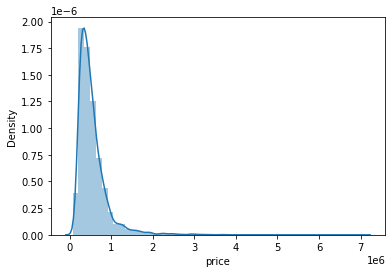

In [8]:
#show distplot
sns.distplot(df_train['price'])

In [9]:
len(df_train)*0.01

129.67000000000002

D:\64bits\anaconda\envs\pt-gpu\lib\site-packages\seaborn\distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


<AxesSubplot:xlabel='price', ylabel='Density'>

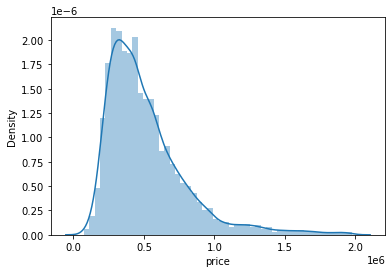

In [11]:
#accuracy is lower than origin, so I didn't use it
df_train_2 =df_train.sort_values(['price'], ascending=False).iloc[129:]
sns.distplot(df_train_2['price'])

In [12]:
#so I drop id, sale_day, sale_month, zipcode
df_train = df_train.drop(["id"],axis=1)
df_train = df_train.drop(["zipcode"],axis=1)
df_train = df_train.drop(["sale_day"],axis=1)
df_train = df_train.drop(["sale_month"],axis=1)

In [13]:
#split x, y
x_train = df_train.iloc[:,1:]
y_train = df_train.iloc[:,0:1]

In [15]:
df_valid = pd.read_csv('./datasets/valid-v3.csv')

D:\64bits\anaconda\envs\pt-gpu\lib\site-packages\seaborn\distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


<AxesSubplot:xlabel='price', ylabel='Density'>

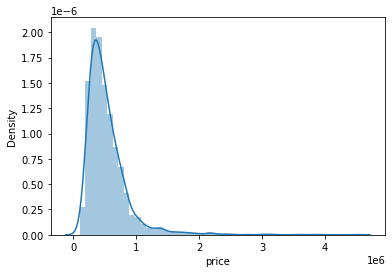

In [16]:
#show valid distplot
sns.distplot(df_valid['price'])

In [17]:
df_valid = df_valid.drop(["id"],axis=1)
df_valid = df_valid.drop(["zipcode"],axis=1)
df_valid = df_valid.drop(["sale_day"],axis=1)
df_valid = df_valid.drop(["sale_month"],axis=1)

In [18]:
x_valid = df_valid.iloc[:,1:]
y_valid = df_valid.iloc[:,0:1]

In [19]:
#normalize
def norm_stats(df1, df2):
    dfs = df1.append(df2)
    minimum = np.min(dfs)
    maximum = np.max(dfs)
    mu = np.mean(dfs)
    sigma = np.std(dfs)
    return (minimum, maximum, mu, sigma)
def z_score(col, stats):
    m, M, mu, s = stats
    df = pd.DataFrame()
    for c in col.columns:
        df[c] = (col[c]-mu[c])/s[c]
    return df

In [20]:
stats = norm_stats(x_train, x_valid)

In [21]:
arr_x_train = np.array(z_score(x_train, stats))
arr_y_train = np.array(y_train)
arr_x_valid = np.array(z_score(x_valid, stats))
arr_y_valid = np.array(y_valid)

print('Training shape:', arr_x_train.shape)

Training shape: (12967, 18)


In [29]:
#convert cpu(np) to gpu(tensor)
inputs = torch.Tensor(arr_x_train)
targets = torch.Tensor(arr_y_train)
train_dataset = TensorDataset(inputs, targets)

In [30]:
inputs = torch.Tensor(arr_x_valid)
targets = torch.Tensor(arr_y_valid)
val_dataset = TensorDataset(inputs, targets)

In [31]:
#batch size 32
batch_size = 32
train_loader = DataLoader(train_dataset, batch_size, shuffle = True)
val_loader = DataLoader(val_dataset, batch_size, shuffle = True)

# Training

In [32]:
# linear neutral network
class LinearNeutralNetworkModel_gpu(nn.Module):
    def __init__(self,input_size,H1,H2,output_size):
        super().__init__()
        self.layers = nn.Sequential(
          nn.Linear(input_size, H1),
          nn.ReLU(True),
          nn.Linear(H1, H2),
          nn.ReLU(True),
          nn.Linear(H2, output_size)
        )
    def forward(self, xb):
        return self.layers(xb)
    
    def training_step(self, batch):
        inputs, targets = batch 
        inputs = inputs.to(device)
        targets = targets.to(device)
        # Generate predictions
        out = self(inputs)          
        # Calcuate loss l1lose = mae loss
        loss = F.l1_loss(input = out, target = targets, size_average = None, reduce = None, reduction = 'mean')  
        return loss
    
    def validation_step(self, batch):
        inputs, targets = batch
        inputs = inputs.to(device)
        targets = targets.to(device)
        # Generate predictions
        out = self(inputs)
        # Calculate loss
        loss = F.l1_loss(input = out, target = targets, size_average = None, reduce = None, reduction = 'mean')   
        return {'val_loss': loss.detach()}
        
    def validation_epoch_end(self, outputs):
        batch_losses = [x['val_loss'] for x in outputs]
        epoch_loss = torch.stack(batch_losses).mean()   # Combine losses
        return {'val_loss': epoch_loss.item()}
    
    def epoch_end(self, epoch, loss, result, num_epochs, lr):
        # Print result every num_epochs/10 
        if (epoch+1) % (num_epochs/10) == 0 or epoch == num_epochs-1:
            print("Epoch [{}], train_loss: {:.4f}, val_loss: {:.4f}, lr: {}".format(epoch+1, loss, result['val_loss'],lr))

In [34]:
# layers
model = LinearNeutralNetworkModel_gpu(18,1000,300,1)
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
model.to(device)
list(model.parameters())

[Parameter containing:
 tensor([[ 0.1011,  0.2021, -0.0732,  ...,  0.0473, -0.2284,  0.1125],
         [ 0.1215, -0.0834,  0.1664,  ...,  0.1854,  0.1894,  0.1583],
         [ 0.0738, -0.0904,  0.2084,  ..., -0.1476,  0.0595, -0.1977],
         ...,
         [-0.0055, -0.1162,  0.1735,  ..., -0.0696,  0.1788, -0.1890],
         [-0.2295, -0.0771,  0.0087,  ..., -0.0274, -0.0696, -0.0869],
         [-0.0898, -0.0459, -0.0150,  ..., -0.1051,  0.1325,  0.1407]],
        device='cuda:0', requires_grad=True),
 Parameter containing:
 tensor([ 1.0449e-01,  1.2670e-01, -5.5051e-02, -7.4825e-02,  8.1264e-02,
         -1.5450e-01, -9.3130e-02, -4.2281e-02, -1.4635e-01,  4.6862e-02,
         -1.8151e-01,  2.0868e-01, -2.1688e-02, -4.2819e-02, -7.9121e-02,
         -2.1254e-01, -1.7681e-01, -9.1608e-02, -2.2071e-01,  1.8944e-01,
          5.1804e-02,  6.6212e-02,  2.0368e-01,  2.1186e-01,  2.2875e-02,
         -4.1366e-02,  1.8076e-02,  7.4957e-02, -8.6810e-02,  1.9522e-01,
         -6.4422e-02,  

In [36]:
def evaluate_gpu(model, val_loader):
    outputs = [model.validation_step(batch) for batch in val_loader]
    return model.validation_epoch_end(outputs)

def fit_gpu(epochs, lr, model, train_loader, val_loader, opt_func = torch.optim.Adam):
    history = []
    optimizer = opt_func(model.parameters(), lr, betas=(0.9, 0.999), eps=1e-08, weight_decay=0, amsgrad=False)
    #ReduceLROnPlateau: Reduce learning rate when a metric has stopped improving
    scheduler = ReduceLROnPlateau(optimizer, 'min', factor=0.1, patience=2)
    print(optimizer)
    for epoch in range(epochs):
        # Training Phase 
        for batch in train_loader:
            loss = model.training_step(batch)
            loss.backward()
            optimizer.step()
            optimizer.zero_grad()
        # Validation phase
        result = evaluate_gpu(model, val_loader)
        scheduler.step(result['val_loss'])
        model.epoch_end(epoch, loss ,result, epochs, optimizer.param_groups[0]['lr'])
        history.append(result)
    return history

In [37]:
result = evaluate_gpu(model, val_loader)
print(result)

{'val_loss': 529616.8125}


In [40]:
#epochs 60
epochs = 60
lr = 0.1
history1 = fit_gpu(epochs, lr, model, train_loader, val_loader)

Adam (
Parameter Group 0
    amsgrad: False
    betas: (0.9, 0.999)
    eps: 1e-08
    lr: 0.1
    weight_decay: 0
)
Epoch [6], train_loss: 41116.4844, val_loss: 66783.0000, lr: 0.010000000000000002
Epoch [12], train_loss: 36795.6719, val_loss: 62610.8672, lr: 0.0010000000000000002
Epoch [18], train_loss: 16732.1387, val_loss: 62766.2070, lr: 1.0000000000000004e-05
Epoch [24], train_loss: 78351.4141, val_loss: 62514.2227, lr: 1.0000000000000005e-07
Epoch [30], train_loss: 55547.6328, val_loss: 62728.4570, lr: 1.0000000000000005e-08
Epoch [36], train_loss: 55212.8789, val_loss: 62574.8086, lr: 1.0000000000000005e-08
Epoch [42], train_loss: 172202.6250, val_loss: 62536.0586, lr: 1.0000000000000005e-08
Epoch [48], train_loss: 56991.3438, val_loss: 62505.8516, lr: 1.0000000000000005e-08
Epoch [54], train_loss: 19275.9785, val_loss: 62588.8828, lr: 1.0000000000000005e-08
Epoch [60], train_loss: 44692.5703, val_loss: 62521.7070, lr: 1.0000000000000005e-08


# Output

In [41]:
#save model and handle test to csv
torch.save(model,'model_20211119.pt')
arr_x_train = np.array(z_score(x_train, stats))
df_test = pd.read_csv('./datasets/test-v3.csv')
df_test = df_test.drop(["id"],axis=1)
df_test = df_test.drop(["zipcode"],axis=1)
df_test = df_test.drop(["sale_day"],axis=1)
df_test = df_test.drop(["sale_month"],axis=1)
arr_x_train = np.array(z_score(df_test, stats))
results_list = []
test_array = arr_x_train
for test in test_array:
    tests = torch.Tensor(test)
    tests.unsqueeze(0)
    predictions = model(tests.to(device))
    prediction = predictions[0].detach()
    results_list.append(int(round(prediction.item())))
    print(int(round(prediction.item())))
id_list = [i+1 for i in range(0,len(results_list))]
df = pd.DataFrame(list(zip(id_list,results_list)), columns=["id","price"])
df.to_csv("./test.csv",index=False)


675064
668801
513771
409771
949078
416998
204055
319997
353340
531013
1116495
360175
1981053
532558
553042
1494374
543750
394831
536814
428892
501034
1338320
526468
709890
305785
184425
595044
227590
588993
156259
708028
668302
433130
147038
240549
210782
285144
609452
652586
751183
736729
442537
826715
234075
263656
548873
418365
867209
1011229
2559604
359859
970248
760249
346059
536091
493107
556278
553923
238842
244307
215117
228419
403702
808602
302378
478707
784459
304233
826131
583371
430891
476430
637191
900428
499644
3255908
266468
633675
467895
2125608
216731
430529
439856
851956
385995
405069
423598
313775
385892
253500
527749
252391
590549
418297
859273
632356
1211700
406764
652341
283171
533443
416684
285768
412107
279337
769898
667979
446895
590341
369480
668750
534509
298829
413581
252899
354540
287247
842975
160940
276879
1000568
316987
352568
591735
321613
322708
633957
782015
776518
233507
678479
481269
360033
448556
437622
656311
1117800
296096
526769
722016
702090
30

688224
390526
471898
849124
294639
305401
282238
104205
226324
1009482
769170
277443
526698
518259
375940
365117
355820
437854
532552
587988
342081
209331
598730
778179
436571
844265
1089681
435244
197183
401524
1277184
453079
430306
590733
277402
845287
398160
418518
275063
503488
467768
845776
417205
627430
870199
1328242
248456
475331
475397
367733
419286
842679
2219101
457306
876554
279515
307817
272392
312408
691749
242564
204609
594677
488563
253986
620588
435687
488285
266502
623986
578107
410473
421849
191162
274717
561134
727106
356460
427638
536051
926420
364920
503110
223245
390311
277487
545503
631128
410454
487762
550556
492379
252753
712759
610175
372648
310082
670349
267233
1523346
439663
360888
513197
390212
579374
308138
415302
536457
428071
309375
385777
242050
291149
758004
158718
413539
500564
282827
529400
433711
343640
348094
886357
253156
402358
1108207
389324
362782
312263
475565
419252
238112
659611
405995
533297
835031
476041
398094
375544
331670
205945
522812

620884
756895
379380
699873
479848
285299
382650
433901
329164
475848
419806
164002
1551059
1285819
336687
310303
425167
230527
843841
435374
425573
570391
395835
955189
1703959
412339
588921
287707
229774
406556
495543
288183
510814
407658
1464366
401744
343933
374056
404280
605110
792536
419865
335179
455214
828268
341743
959183
608215
197480
495489
265469
264638
646005
333858
526224
460783
427727
687654
512310
237847
450393
455107
546375
938145
704411
605628
312165
699673
680530
392066
212139
524297
640575
1994169
389241
757094
610392
282706
521332
456006
513056
321591
159671
393905
486012
636197
465362
483194
472070
466594
223811
325888
576405
473249
772257
286981
220345
517104
253526
933631
767680
2113883
301121
260520
636934
1626429
647458
473851
310714
263343
564452
418760
258329
333710
586362
369780
317582
456634
337642
623981
724522
332773
549578
838806
361397
371772
322421
231016
230112
637638
388666
240745
431399
1965886
353840
607145
437675
716285
580353
517957
241023
35598

553095
781585
281509
534231
531863
324380
728156
522035
654120
446354
209274
707867
349460
364141
448341
330083
675611
1029192
580632
581539
583432
339568
1740692
276617
206183
1322385
717094
280373
507723
739425
227580
642235
323413
516068
388595
890430
386638
505438
668932
478068
381856
114369
302570
182111
296298
250345
231382
285804
274623
460894
1767087
794138
111410
1037776
378869
1785404
958061
333744
345084
343797
840415
516933
505162
650460
355027
810636
227789
247309
210309
480568
702667
323006
554149
428073
261046
459860
725869
762943
380105
362372
365725
210615
411414
377628
498766
201333
322771
329670
606357
232433
600356
279047
762262
748810
434117
398935
433501
620268
478487
617569
656760
397392
303949
497120
361604
593662
246997
409856
549544
329140
351912
329245
425743
254395
262028
442236
437914
413374
1002177
652101
482644
313458
245050
543241
579191
313722
582306
630686
520083
210685
315609
535680
1154973
358358
525580
734721
810178
621788
305243
1778539
388283
6227

335699
363444
654625
277338
378140
382732
400892
873080
320448
1325990
636467
687752
336759
1509065
784042
639622
845905
280047
224594
575119
368777
1117464
735079
1596069
1031170
889674
749989
649381
264475
568104
348836
365043
574852
927205
669904
504189
269212
535934
141584
416734
403582
294965
316289
930374
995230
825577
418068
880576
383118
439208
415515
236928
354363
240859
790116
588784
381219
259275
932841
274999
394561
297356
378167
277116
649202
409462
339602
270824
373616
649931
368047
472866
182578
2129686
577291
481729
297860
226889
172079
417572
215447
259952
751308
269845
1481565
180979
355604
543982
414872
622194
929549
197843
516115
809975
1083304
460729
757420
1400693
330579
347508
908671
941665
362449
405498
283465
857686
664612
374429
453113
263106
641675
352684
412558
356307
599212
267864
944786
348944
867246
483293
699993
246583
478838
338488
567877
252844
426524
437475
643484
467779
469547
767557
752105
598709
450154
206091
754324
297195
505483
628067
287148
5402

334076
737594
506268
306214
1095339
213746
313342
1025926
440221
460337
367487
225587
234073
259420
206463
216620
290611
287605
959527
676764
498660
370415
595455
708082
246716
600517
497504
1088402
358465
506750
793907
248273
505298
371318
924392
297780
1164328
515829
644772
427231
1239214
273139
945052
423356
406506
529282
800416
280020
492898
208146
408479
1707872
357098
266149
423941
200925
699376
373224
247692
368847
325030
271499
397969
405649
221069
336207
745629
722855
526190
353613
621336
448725
800215
371798
259402
610141
665936
587184
273747
549853
416447
681221
399310
467381
268283
714452
719770
541471
357318
534001
440612
681867
756134
902013
483737
407418
429502
1352428
652056
317652
682902
1173952
376455
461066
495131
503227
256411
176075
429297
710999
653762
450964
591262
246268
200385
210085
297934
260817
704448
513145
568346
682793
698239
777483
705253
800087
333515
362601
480747
1245464
498789
436996
546344
276204
459471
690197
424153
271580
452681
935775
191618
5550